In [1]:
import os
import copy
import time
import random
import numpy as np

import functools

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

SEED = 241

In [2]:
def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
class VGG(nn.Module):

  def __init__(self, features, output_dim):
    super().__init__()
    self.features = features
    self.pooling = nn.AdaptiveAvgPool2d(7)
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.pooling(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

In [4]:
def get_vgg_layers(config, batch_norm=False):
  layers = []
  in_channels = 3
  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layer = nn.MaxPool2d(2)
      layers.append(layer)
    else:
      layer = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
      layers.append(layer)
      if batch_norm:
        layer = nn.BatchNorm2d(c)
        layers.append(layer)
      layer = nn.ReLU()
      layers.append(layer)
      in_channels = c
  layers = nn.Sequential(*layers)
  return layers

In [5]:
output_dim = 10
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

features = get_vgg_layers(vgg11_config, batch_norm=True)
model = VGG(features, output_dim)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [6]:
import torchvision.models as vision_models


vgg_pretrained = vision_models.vgg11_bn(pretrained=True)
in_features = vgg_pretrained.classifier[-1].in_features
vgg_pretrained.classifier[-1] = nn.Linear(in_features, output_dim)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


![vgg net](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg.png?raw=true)

In [7]:
print(vgg_pretrained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
vgg_pretrained_params = list(vgg_pretrained.named_parameters())
model_params = list(model.named_parameters())

assert len(vgg_pretrained_params) == len(model_params)

for i in range(len(vgg_pretrained_params)):
  assert vgg_pretrained_params[i][0] == model_params[i][0]

In [9]:
def count_model_params(model):
  num_params = np.sum([param.numel() for name, param in model.named_parameters()])
  print('model params: %e' % num_params)
  return num_params

In [10]:
count_model_params(vgg_pretrained)
count_model_params(model)

model params: 1.288128e+08
model params: 1.288128e+08


128812810

In [11]:
model.load_state_dict(vgg_pretrained.state_dict())

for param in model.features.parameters():
  param.requires_grad = False

# for param in model.classifier[:-1].parameters():
#   param.requires_grad = False

In [12]:
input_pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
  transforms.Resize(input_pretrained_size),
  transforms.RandomRotation(5),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize(pretrained_means, pretrained_stds)
])

test_transforms = transforms.Compose([
  transforms.Resize(input_pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(pretrained_means, pretrained_stds)
])

In [13]:
ROOT = '.data'

train = datasets.CIFAR10(ROOT, train=True, transform=train_transforms, download=True)
test = datasets.CIFAR10(ROOT, train=False, transform=test_transforms, download=True)

Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


In [14]:
print(f'Len train: {len(train)}')
print(f'Len test: {len(test)}')

Len train: 50000
Len test: 10000


In [15]:
def normalize_image(image):
  img_max = image.max()
  img_min = image.min()
  normalized = (image - img_min) / (img_max - img_min + 1e-5)
  return normalized

def plot_images(image_label_pairs, class_mapping, n_cols=5):
  n_images = len(image_label_pairs)
  n_rows = n_images // n_cols
  if n_images % n_cols != 0:
    n_rows += 1
  
  fig = plt.figure(figsize=(10, 7))
  for i in range(n_images):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    img, label = image_label_pairs[i]
    img = normalize_image(img)
    img = img.permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.set_title(class_mapping[label])

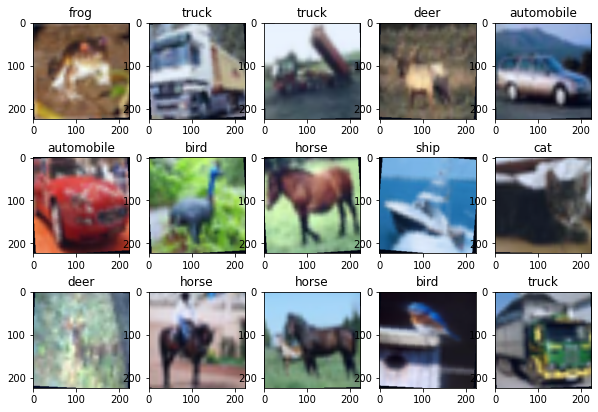

In [16]:
images_to_plot = [train[i] for i in range(15)]
class_mapping = train.classes

plot_images(images_to_plot, class_mapping)

In [17]:
class LearningRateFinder:

  """
  On Every batch call ExpLR Scheduler and finds exp smooth on losses.
  Tries to find the minimum loss and corresponding learning rate updating the model.
  Finally restores original model state dict.
  """

  def __init__(self, model, optimizer, criterion, device):
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.device = device

    torch.save(model.state_dict(), 'init_params.pt')

  def range_test(self, iterator, num_iter, gamma=0.5, smooth=0.05, diverge=5):
    # iterator - iterator for data
    # num_iter - num iterations to decreate lr
    # gamma - lr decresing param
    # smooth - exp smooth for loss calc
    # diverge - thresold for nondecreasing error agains best loss

    losses = []
    learning_rates = []
    best_loss = np.float('inf')

    data_iterator = IteratorWrapper(iterator)
    lr_scheduler = opt.lr_scheduler.ExponentialLR(self.optimizer, gamma)

    for iteration in range(num_iter):
      loss = self._train_batch(data_iterator)
      learning_rates.append(lr_scheduler.get_last_lr()[0])
      lr_scheduler.step()

      if iteration > 0:
        loss = smooth * loss + (1 - smooth) * losses[-1]

      if loss < best_loss:
        best_loss = loss

      losses.append(loss)

      if loss > diverge * best_loss:
        print('Early stopping')
        break

    model.load_state_dict(torch.load('init_params.pt'))
    return losses, learning_rates

  def _train_batch(self, iterator):
    self.model.train()
    self.optimizer.zero_grad()

    x, y = iterator.get_batch()
    x = x.to(self.device)
    y = y.to(self.device)

    y_pred, _ = self.model(x)
    loss = self.criterion(y_pred, y)
    
    loss.backward()
    optimizer.step()

    return loss.detach().cpu().item()


class IteratorWrapper:
  """
  To hanlde always the same batch_size.
  """

  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)

  def __next__(self):
    try:
      inputs, labels = next(self._iterator)
    except StopIteration:
      self._iterator = iter(self.iterator)
      inputs, labels = next(self._iterator)
    return inputs, labels

  def get_batch(self):
    return next(self)

In [18]:
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = data.DataLoader(train, batch_size=batch_size)
valid_loader = data.DataLoader(test, batch_size=batch_size)

In [19]:
start_learning_rate = 1e-5

optimizer = opt.Adam(model.parameters(), lr=start_learning_rate)
criterion = nn.CrossEntropyLoss()

model.load_state_dict(vgg_pretrained.state_dict())

for param in model.features.parameters():
  param.requires_grad = False

for param in model.classifier[:-1].parameters():
  param.requires_grad = False

model = model.to(device)
criterion = criterion.to(device)

Early stopping


Text(0, 0.5, 'LR')

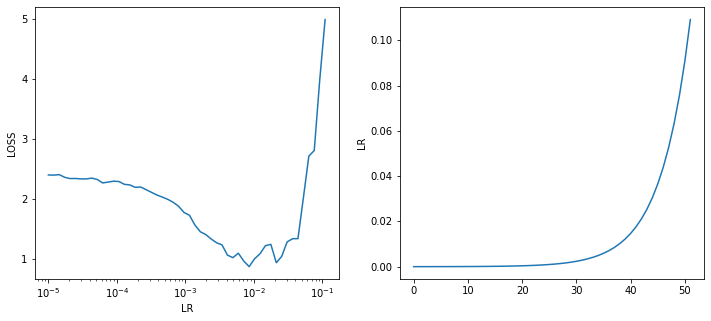

In [20]:
lr_finder = LearningRateFinder(model, optimizer, criterion, device)
losses, learning_rates = lr_finder.range_test(train_loader, num_iter=100, gamma=1.2, smooth=0.7, diverge=5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(learning_rates, losses)
axes[0].set_xscale('log')
axes[0].set_xlabel('LR')
axes[0].set_ylabel('LOSS')

axes[1].plot(learning_rates)
# axes[1].set_yscale('log')
axes[1].set_ylabel('LR')

In [21]:
learning_rate = 5e-3

optimizer = opt.Adam(model.parameters(), lr=learning_rate)

In [22]:
def calc_accuracy(y_pred, target):
  y_pred = torch.argmax(y_pred, dim=1)
  correct = (y_pred == target).sum()
  return correct / target.shape[0]

In [23]:
from tqdm import tqdm

In [24]:
def train_epoch(model, iterator, optimizer, criterion, device):
  model.train()
  
  error = 0
  accuracy = 0

  for batch in tqdm(iterator):
    optimizer.zero_grad()

    x, y = batch

    x = x.to(device)
    y = y.to(device)

    y_pred, _ = model(x)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    error += loss.item()
    accuracy += calc_accuracy(y_pred, y)

  return error / len(iterator), accuracy / len(iterator)


def valid_epoch(model, iterator, criterion, device):
  model.eval()

  error = 0
  accuracy = 0

  with torch.no_grad():
    for batch in tqdm(iterator):
      x, y = batch

      x = x.to(device)
      y = y.to(device)

      y_pred, _ = model(x)

      loss = criterion(y_pred, y)
      error += loss.item()
      accuracy += calc_accuracy(y_pred, y)

  return error / len(iterator), accuracy / len(iterator)

In [25]:
for epoch in range(1):
  train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
  valid_loss, valid_acc = valid_epoch(model, valid_loader, criterion, device)

  print(f'Epoch: {epoch + 1}, Train loss: {train_loss} acc: {train_acc}, Valid loss: {valid_loss} acc: {valid_acc}')

100%|██████████| 79/79 [00:42<00:00,  1.86it/s]

Epoch: 1, Train loss: 1.026557137441757 acc: 0.6837276220321655, Valid loss: 0.8150147403342815 acc: 0.7508900761604309


In [26]:
def predict(model, image, label, class_mapping, device):
  model.eval()
  with torch.no_grad():
    image = image.to(device)
    y_pred, hidden = model(image.unsqueeze(0))
    y_pred = y_pred.detach().cpu().numpy()
    y_pred_class = y_pred.argmax(axis=1)[0]
    
    image = image.permute(1, 2, 0).cpu().numpy()
    image = normalize_image(image)
    plt.imshow(image)
    plt.title(f'True: {class_mapping[label]} | Pred: {class_mapping[y_pred_class]}')

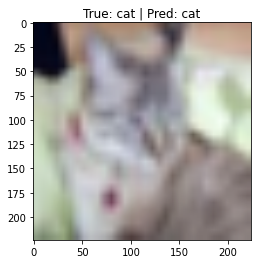

In [27]:
index = 8

predict(model, test[index][0], test[index][1], class_mapping, device)

In [28]:
def plot_filters(model, n_cols=5, figsize=(5, 5)):
  filters = model.features[0].weight.data
  n_filters = filters.size(0)

  n_rows = n_filters // n_cols
  if n_filters % n_cols != 0:
    n_rows += 1

  fig = plt.figure(figsize=figsize)
  for i in range(n_filters):
    filter = filters[i].detach().cpu()

    filter = normalize_image(filter)

    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    ax.imshow(filter)
    ax.axis('off')

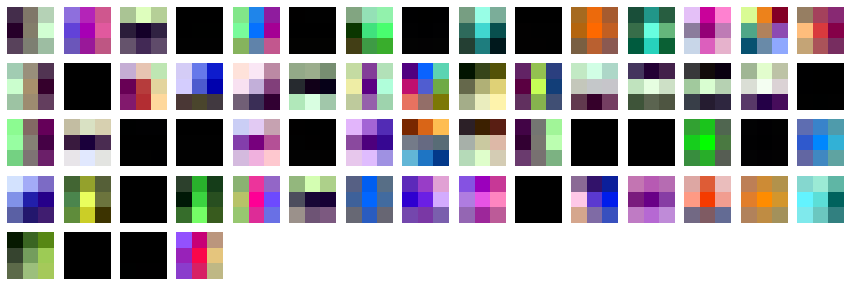

In [29]:
plot_filters(model, n_cols=15, figsize=(15, 5))

In [30]:
def plot_filtered_images(model, images, n_cols=5, figsize=(5, 5)):
  filters = [p.weight.data for p in model.features if isinstance(p, nn.Conv2d)][0]
  n_filters = len(filters)

  if n_cols > n_filters:
    n_cols = n_filters

  n_rows = len(images)
  images = torch.stack(images, dim=-1)
  images = images.permute(3, 0, 1, 2)
  images = images.to(device)
  filtered_images = F.conv2d(images, filters)

  fig = plt.figure(figsize=figsize)
  for i in range(n_rows):
    filters_for_one_image = filtered_images[i].detach().cpu()
    for j in range(n_cols + 1):
      ax = fig.add_subplot(n_rows, n_cols + 1, i*(n_cols + 1) + j + 1)
      if j == 0:
        original = images[i].cpu().permute(1, 2, 0).numpy()
        original = normalize_image(original)
        ax.imshow(original)
      else:
        sinble_filtered_image = filters_for_one_image[j].cpu()
        sinble_filtered_image = normalize_image(sinble_filtered_image)
        ax.imshow(sinble_filtered_image)
      ax.axis('off')

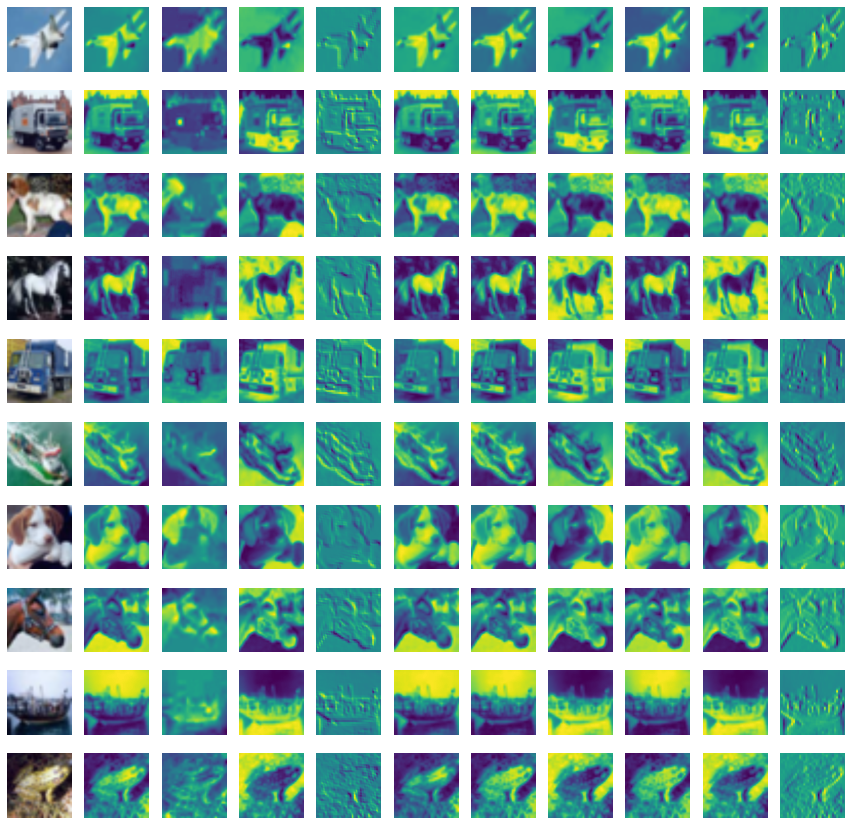

In [31]:
plot_filtered_images(model, [test[i][0] for i in range(10, 20)], n_cols=10, figsize=(15, 15))